In [136]:
#Import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import hvplot.pandas


In [137]:
# Set pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [138]:
#Define Functions

# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define Bollinger Band function
def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

# Function to calculate daily volatility
def calculate_daily_volatility(prices):
    returns = prices.pct_change(fill_method=None)
    volatility = returns.rolling(window=21).std() * np.sqrt(252)  # Annualized daily volatility
    return volatility

# Function to calculate trade Action to do
def calculate_signals(today_to_tomorrow, yesterday_to_today):
    """
    Calculate the primary trading signals based on price differences.
    """
    conditions = [
        (today_to_tomorrow == 1) & (yesterday_to_today == -1),  # Buy signal: rising tomorrow, falling today
        (today_to_tomorrow == 1) & (yesterday_to_today == 1),   # Hold signal: rising tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == 1),   # Hold signal: no change tomorrow, rising today
        (today_to_tomorrow == 1) & (yesterday_to_today == 0),   # Hold signal: rising tomorrow, no change today
        (today_to_tomorrow == -1) & (yesterday_to_today == 1),  # Sell signal: falling tomorrow, rising today
        (today_to_tomorrow == -1) & (yesterday_to_today == -1), # Short signal: falling tomorrow and today
        (today_to_tomorrow == 0) & (yesterday_to_today == -1),  # Short signal: no change tomorrow, falling today
        (today_to_tomorrow == -1) & (yesterday_to_today == 0)   # Short signal: falling tomorrow, no change today
    ]
    choices = ["buy", "hold", "hold", "hold", "sell", "short", "short", "short"]
    
    initial_actions = pd.Series(
        np.select(conditions, choices, default=pd.NA),
        index=today_to_tomorrow.index
    )
    return initial_actions

def handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today):
    """
    Handle neutral cases where both today-to-tomorrow and yesterday-to-today differences are zero.
    This function updates the action based on the previous action.
    """
    neutral_mask = (today_to_tomorrow == 0) & (yesterday_to_today == 0)
    prev_actions = actions.shift(1)

    actions.loc[neutral_mask] = np.where(
        prev_actions.loc[neutral_mask].isin(["buy", "hold"]),
        "hold",
        np.where(prev_actions.loc[neutral_mask].isin(["short", "sell"]), "short", pd.NA)
    )
    
    return actions

def generate_trading_signals(data):
    """
    Generate trading signals by first calculating primary signals and then handling neutral cases.
    """
    # Shift the data to get the price differences
    next_day = data.shift(-1)
    prev_day = data.shift(1)

    # Calculate the difference between today's and tomorrow's prices and yesterday's and today's prices
    today_to_tomorrow = np.sign(next_day - data)
    yesterday_to_today = np.sign(data - prev_day)

    # Part 1: Calculate primary signals
    actions = calculate_signals(today_to_tomorrow, yesterday_to_today)

    # Part 2: Handle neutral cases
    actions = handle_neutral_cases(actions, today_to_tomorrow, yesterday_to_today)

    return actions

In [139]:
# Fetch S&P 500 tickers
#Define dates
start_date = '2000-09-30'
end_date = '2024-10-21'

#Get tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

print(f"Initial total S&P 500 tickers: {len(sp500_tickers)}")

Initial total S&P 500 tickers: 501


In [140]:
store_array = []
for ticker in sp500_tickers:
    try:
        ticker = yf.Ticker(ticker)
        data = ticker.history(period="1d", interval="1m")
        data.sort_values(by='Datetime', ascending=False, inplace=True)
        store_array.append({
            "ticker": ticker,
            "data": data
        })
    except Exception as e:
        print(f"Error fetching {ticker}: {e}")
        

In [141]:
print(store_array[1]['data'])

                            Open   High    Low  Close  Volume  Dividends  \
Datetime                                                                   
2024-10-21 15:59:00-04:00 78.505 78.630 78.480 78.600   75307      0.000   
2024-10-21 15:58:00-04:00 78.440 78.505 78.440 78.505   35941      0.000   
2024-10-21 15:57:00-04:00 78.380 78.460 78.380 78.440   26481      0.000   
2024-10-21 15:56:00-04:00 78.300 78.380 78.290 78.380   17717      0.000   
2024-10-21 15:55:00-04:00 78.300 78.310 78.240 78.300   18215      0.000   
...                          ...    ...    ...    ...     ...        ...   
2024-10-21 09:35:00-04:00 79.100 79.120 79.040 79.060    2688      0.000   
2024-10-21 09:33:00-04:00 79.210 79.210 79.200 79.200     511      0.000   
2024-10-21 09:32:00-04:00 79.260 79.260 79.180 79.195    1443      0.000   
2024-10-21 09:31:00-04:00 78.932 79.300 78.932 79.260    3985      0.000   
2024-10-21 09:30:00-04:00 78.860 78.910 78.830 78.860   14788      0.000   

           

In [142]:
# Download historical prices
data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Check if data was downloaded for all tickers
print(f"Successfully downloaded tickers: {len(data.columns)} out of {len(sp500_tickers)}")

[*********************100%***********************]  501 of 501 completed


Successfully downloaded tickers: 501 out of 501


In [143]:
# Display data Frame
data.head(15)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-02 00:00:00+00:00,30.522,0.366,0.000,0.000,11.516,1.750,0.000,40.487,52.558,5.108,...,0.000,6.296,0.000,10.493,21.408,0.000,3.827,0.000,19.694,0.000
2000-10-03 00:00:00+00:00,32.069,0.336,0.000,0.000,11.591,1.764,0.000,40.595,53.379,5.108,...,0.000,6.577,0.000,10.352,21.261,0.000,3.672,0.000,19.639,0.000
2000-10-04 00:00:00+00:00,34.936,0.356,0.000,0.000,11.381,1.736,0.000,39.245,57.290,5.003,...,0.000,6.743,0.000,10.127,20.896,0.000,3.726,0.000,18.917,0.000
2000-10-05 00:00:00+00:00,33.276,0.333,0.000,0.000,11.441,1.764,0.000,36.885,57.602,5.143,...,0.000,6.754,0.000,9.819,20.881,0.000,3.866,0.000,18.806,0.000
2000-10-06 00:00:00+00:00,31.503,0.335,0.000,0.000,11.516,1.743,0.000,36.668,52.558,5.248,...,0.000,6.598,0.000,10.221,20.940,0.000,3.718,0.000,17.972,0.000
2000-10-09 00:00:00+00:00,30.598,0.328,0.000,0.000,11.456,1.736,0.000,37.180,48.804,5.283,...,0.000,6.515,0.000,10.363,21.335,0.000,3.788,0.000,17.694,0.000
2000-10-10 00:00:00+00:00,29.919,0.315,0.000,0.000,11.786,1.722,0.000,35.690,43.407,5.318,...,0.000,6.400,0.000,10.411,21.847,0.000,3.742,0.000,18.278,0.000
2000-10-11 00:00:00+00:00,27.655,0.296,0.000,0.000,12.073,1.743,0.000,37.428,42.390,5.353,...,0.000,6.577,0.000,10.458,21.949,0.000,3.703,0.000,17.806,0.000
2000-10-12 00:00:00+00:00,27.013,0.302,0.000,0.000,11.998,1.743,0.000,32.492,39.927,5.178,...,0.000,6.473,0.000,10.340,22.037,0.000,3.315,0.000,18.194,0.000


In [144]:
# Display tickers that were successfully downloaded
downloaded_tickers = data.columns.get_level_values(0).unique()
print(f"Successfully downloaded tickers: {len(downloaded_tickers)} out of {len(sp500_tickers)}")

Successfully downloaded tickers: 501 out of 501


In [145]:
# Calculate various indicators
forecast_horizon = 1
returns = data.pct_change()
returns = returns.shift(-forecast_horizon)
daily_volatility = data.apply(calculate_daily_volatility)
rsi = data.apply(calculate_rsi)
sma_50 = data.rolling(window=50).mean()
sma_100 = data.rolling(window=100).mean()
sma_200 = data.rolling(window=200).mean()
upper_band, lower_band = calculate_bollinger_bands(data)
support = data.rolling(window=50).min()
resistance = data.rolling(window=50).max()
actions = data.apply(generate_trading_signals)

In [146]:
# Align data lengths by filling forward and backward
returns.ffill(inplace=True)
returns.bfill(inplace=True)
daily_volatility.ffill(inplace=True)
daily_volatility.bfill(inplace=True)
rsi.ffill(inplace=True)
rsi.bfill(inplace=True)
sma_50.ffill(inplace=True)
sma_50.bfill(inplace=True)
sma_100.ffill(inplace=True)
sma_100.bfill(inplace=True)
sma_200.ffill(inplace=True)
sma_200.bfill(inplace=True)
upper_band.ffill(inplace=True)
upper_band.bfill(inplace=True)
lower_band.ffill(inplace=True)
lower_band.bfill(inplace=True)
support.ffill(inplace=True)
support.bfill(inplace=True)
resistance.ffill(inplace=True)
resistance.bfill(inplace=True)
actions.ffill(inplace=True)
actions.bfill(inplace=True)

In [147]:
lower_band

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-02 00:00:00+00:00,23.394,0.260,0.000,0.000,11.194,1.698,0.000,30.985,34.083,4.895,...,0.000,6.026,0.000,9.451,19.821,0.000,3.150,0.000,16.685,0.000
2000-10-03 00:00:00+00:00,23.394,0.260,0.000,0.000,11.194,1.698,0.000,30.985,34.083,4.895,...,0.000,6.026,0.000,9.451,19.821,0.000,3.150,0.000,16.685,0.000
2000-10-04 00:00:00+00:00,23.394,0.260,0.000,0.000,11.194,1.698,0.000,30.985,34.083,4.895,...,0.000,6.026,0.000,9.451,19.821,0.000,3.150,0.000,16.685,0.000
2000-10-05 00:00:00+00:00,23.394,0.260,0.000,0.000,11.194,1.698,0.000,30.985,34.083,4.895,...,0.000,6.026,0.000,9.451,19.821,0.000,3.150,0.000,16.685,0.000
2000-10-06 00:00:00+00:00,23.394,0.260,0.000,0.000,11.194,1.698,0.000,30.985,34.083,4.895,...,0.000,6.026,0.000,9.451,19.821,0.000,3.150,0.000,16.685,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14 00:00:00+00:00,137.241,219.472,189.547,121.735,110.493,109.439,327.219,486.980,221.624,56.370,...,284.886,32.455,72.944,62.006,111.024,131.944,128.394,101.593,354.386,187.130
2024-10-15 00:00:00+00:00,138.073,221.275,189.541,122.914,110.738,108.595,328.398,486.752,221.700,56.195,...,284.840,32.440,74.920,61.964,111.673,132.029,128.499,101.512,356.245,187.202
2024-10-16 00:00:00+00:00,138.146,222.445,189.384,124.127,110.382,107.736,329.878,486.267,222.530,56.130,...,284.822,32.454,77.453,61.961,112.319,132.128,128.916,101.495,359.642,187.390


In [148]:
print(f"Returns shape: {returns.shape}")
print(returns.head())

print(f"Daily Volatility shape: {daily_volatility.shape}")
print(daily_volatility.head())

print(f"RSI shape: {rsi.shape}")
print(rsi.head())

print(f"SMA_50 shape: {sma_50.shape}")
print(sma_50.head())

print(f"SMA_100 shape: {sma_100.shape}")
print(sma_100.head())

print(f"SMA_200 shape: {sma_200.shape}")
print(sma_200.head())

print(f"Upper Band shape: {upper_band.shape}")
print(upper_band.head())

print(f"Lower Band shape: {lower_band.shape}")
print(lower_band.head())

print(f"Support shape: {support.shape}")
print(support.head())

print(f"Resistance shape: {resistance.shape}")
print(resistance.head())

print(f"Action shape: {actions.shape}")
print(actions.head())

Returns shape: (6050, 501)
Ticker                         A   AAPL  ABBV  ABNB    ABT   ACGL  ACN   ADBE  \
Date                                                                            
2000-10-02 00:00:00+00:00  0.051 -0.080   inf   inf  0.007  0.008  inf  0.003   
2000-10-03 00:00:00+00:00  0.089  0.059   inf   inf -0.018 -0.016  inf -0.033   
2000-10-04 00:00:00+00:00 -0.048 -0.066   inf   inf  0.005  0.016  inf -0.060   
2000-10-05 00:00:00+00:00 -0.053  0.006   inf   inf  0.007 -0.012  inf -0.006   
2000-10-06 00:00:00+00:00 -0.029 -0.020   inf   inf -0.005 -0.004  inf  0.014   

Ticker                       ADI    ADM  ...  WTW     WY  WYNN    XEL    XOM  \
Date                                     ...                                   
2000-10-02 00:00:00+00:00  0.016  0.000  ...  inf  0.045   inf -0.013 -0.007   
2000-10-03 00:00:00+00:00  0.073 -0.021  ...  inf  0.025   inf -0.022 -0.017   
2000-10-04 00:00:00+00:00  0.005  0.028  ...  inf  0.002   inf -0.030 -0.001   
2000-

In [149]:
print(f"Return Length: {len(returns)}")
print(f"Data Length: {len(data.index)}")
print(f"Volatility Length: {len(daily_volatility)}")
print(f"RSI Length: {len(rsi)}")
print(f"SMA_50 Length: {len(sma_50)}")
print(f"SMA_100 Length: {len(sma_100)}")
print(f"SMA_200 Length: {len(sma_200)}")
print(f"Upper Band Length: {len(upper_band)}")
print(f"Lower Band Length: {len(lower_band)}")
print(f"Support Length: {len(support)}")
print(f"Resistance Length: {len(resistance)}")
print(f"Action Length: {len(actions)}")

Return Length: 6050
Data Length: 6050
Volatility Length: 6050
RSI Length: 6050
SMA_50 Length: 6050
SMA_100 Length: 6050
SMA_200 Length: 6050
Upper Band Length: 6050
Lower Band Length: 6050
Support Length: 6050
Resistance Length: 6050
Action Length: 6050


In [114]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
    'Action': actions.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance', 'Action'], inplace=True)

# Display DataFrame
indicators_df.head()

# filter out tickers not AAPL
apple_df = indicators_df[indicators_df['Ticker'] == 'AAPL']

apple_df.sort_values(by='Date', ascending=False, inplace=True)
apple_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action


# One Hot Encoder: Encoding

In [73]:
# endcode the action column
# Create an instance of the OneHotEncoder
from sklearn.preprocessing import OneHotEncoder


enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
enc.set_output(transform='pandas')

stock_actions_encoded = enc.fit_transform(indicators_df[['Action']])

indicators_df = pd.concat([indicators_df, stock_actions_encoded], axis=1)
final_df = indicators_df.drop(columns=['Action'])


In [30]:
indicators_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2020-10-01 00:00:00+00:00,A,98.455,-0.012,0.252,66.580,105.846,112.824,122.027,105.608,97.907,97.278,115.772,buy
1,2020-10-01 00:00:00+00:00,AAPL,114.132,-0.032,0.449,51.119,115.055,122.170,124.556,120.359,108.014,106.295,121.759,buy
2,2020-10-01 00:00:00+00:00,ABBV,73.216,-0.012,0.292,42.934,79.693,85.449,91.222,75.184,69.560,68.549,92.549,buy
4,2020-10-01 00:00:00+00:00,ABT,100.803,-0.020,0.265,50.214,101.303,104.435,107.231,102.941,98.182,97.750,106.520,buy
5,2020-10-01 00:00:00+00:00,ACGL,29.400,0.010,0.375,56.847,32.238,33.417,36.128,32.184,28.971,29.210,35.300,hold


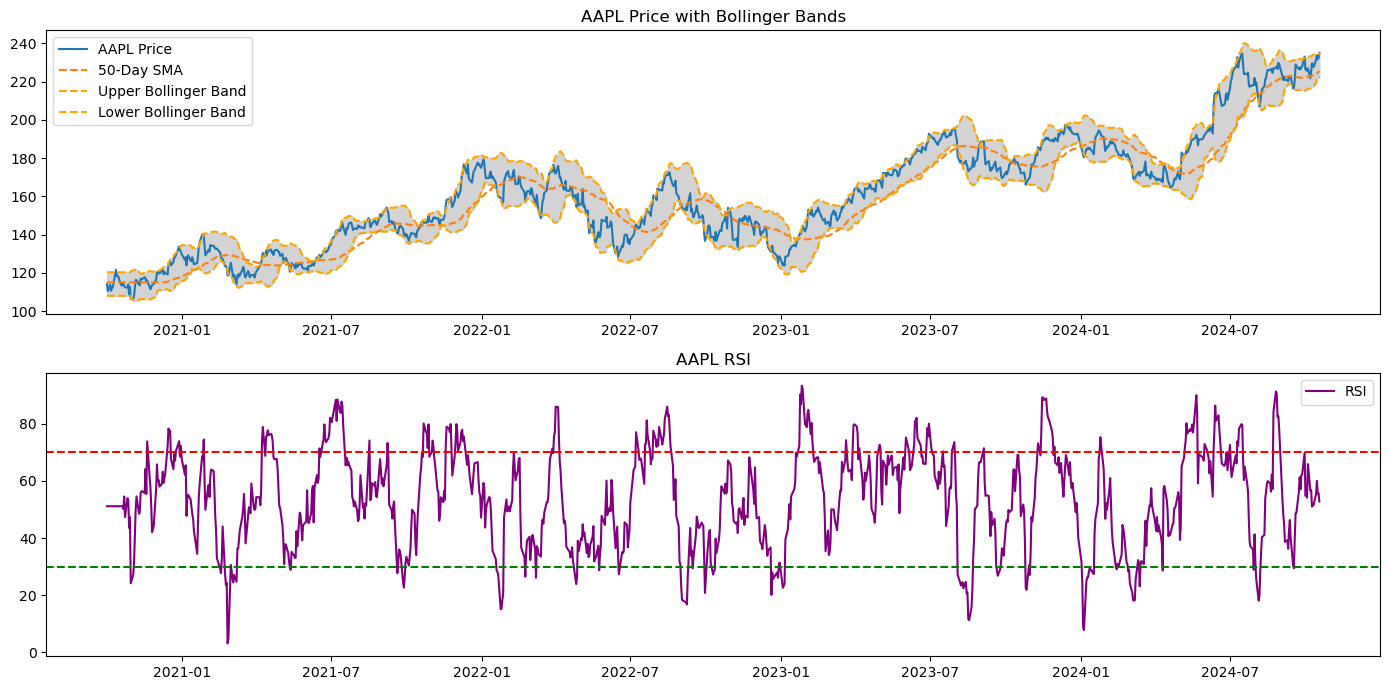

In [74]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [76]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


AttributeError: 'DataFrame' object has no attribute 'hvplot'

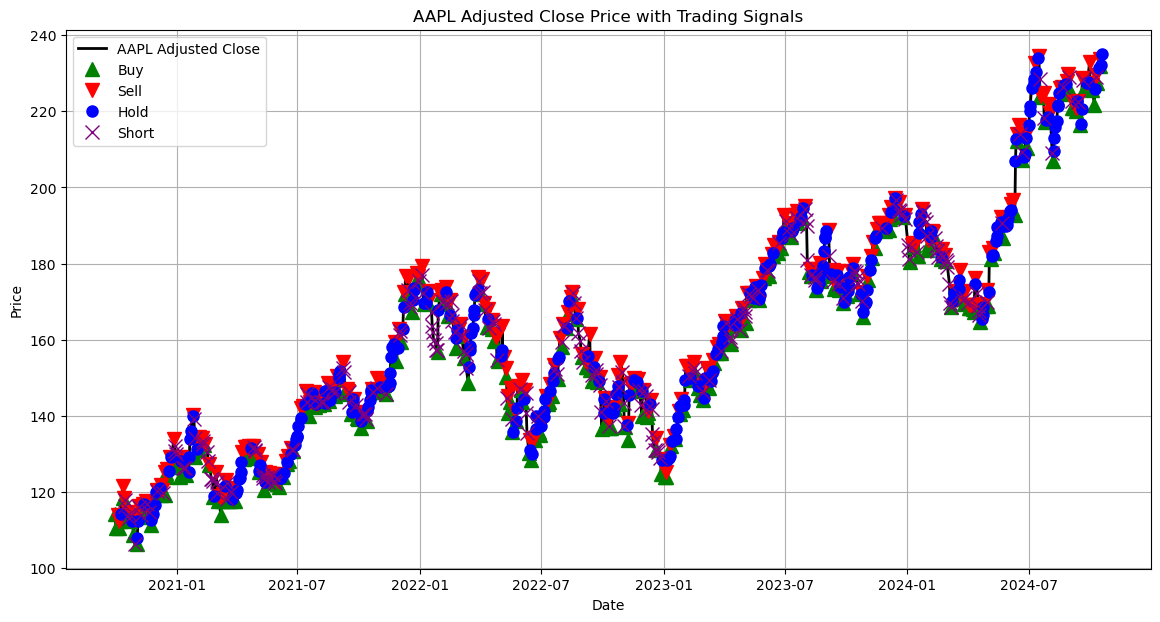

In [77]:
# %% Plot the trading signals for AAPL

ticker_sample = 'AAPL'

# Extract the price data and actions for AAPL
price_data = data[ticker_sample]
actions_aapl = actions[ticker_sample]

# Define marker styles for each action
marker_styles = {
    'buy': {'marker': '^', 'color': 'green', 'label': 'Buy', 'markersize': 10},
    'sell': {'marker': 'v', 'color': 'red', 'label': 'Sell', 'markersize': 10},
    'hold': {'marker': 'o', 'color': 'blue', 'label': 'Hold', 'markersize': 8},
    'short': {'marker': 'x', 'color': 'purple', 'label': 'Short', 'markersize': 10}
}

# Plot the stock price
plt.figure(figsize=(14, 7))
plt.plot(price_data, label=f'{ticker_sample} Adjusted Close', color='black', lw=2)

# Plot the markers for actions
for action, style in marker_styles.items():
    action_mask = actions_aapl == action
    plt.plot(price_data.index[action_mask], price_data[action_mask], 
             style['marker'], color=style['color'], label=style['label'], markersize=style['markersize'])

# Add titles, labels, and legends
plt.title(f'{ticker_sample} Adjusted Close Price with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
# %% Plot the trading signals for AAPL using hvPlot

ticker_sample = 'AAPL'

# Prepare the price data and actions for AAPL
price_data = data[[ticker_sample]].copy()
price_data['Action'] = actions[ticker_sample]

# Define marker styles for each action
action_colors = {'buy': 'green', 'sell': 'red', 'hold': 'blue', 'short': 'purple'}

# Create a base line plot for the adjusted close price
price_plot = price_data.hvplot.line(
    y=ticker_sample, 
    title=f'{ticker_sample} Adjusted Close Price with Trading Signals',
    ylabel='Price', 
    line_width=2,
    height=400,
    width=800,
    legend=False
)

# Overlay the action markers
buy_markers = price_data[price_data['Action'] == 'buy'].hvplot.scatter(
    y=ticker_sample, marker='^', color=action_colors['buy'], size=10, label='Buy'
)
sell_markers = price_data[price_data['Action'] == 'sell'].hvplot.scatter(
    y=ticker_sample, marker='v', color=action_colors['sell'], size=10, label='Sell'
)
hold_markers = price_data[price_data['Action'] == 'hold'].hvplot.scatter(
    y=ticker_sample, marker='o', color=action_colors['hold'], size=6, label='Hold'
)
short_markers = price_data[price_data['Action'] == 'short'].hvplot.scatter(
    y=ticker_sample, marker='x', color=action_colors['short'], size=10, label='Short'
)

# Combine the price plot and the markers
interactive_plot = price_plot * buy_markers * sell_markers * hold_markers * short_markers

# Display the interactive plot with zoom functionality
interactive_plot.opts(legend_position='top_left')
interactive_plot


AttributeError: 'DataFrame' object has no attribute 'hvplot'